# Tukule Kwanza Data Analysis Assesment Workflow

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## Section 1: Data Cleaning and Preparation

### Data Quality Assessment

In [97]:
data = pd.read_excel("Case Study Data - Read Only.xlsx")
print(f"Shape: {data.shape}")
print(data.info())
data.head()

Shape: (333405, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333405 entries, 0 to 333404
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 333405 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  333405 non-null  object        
 2   ANONYMIZED PRODUCT   333405 non-null  object        
 3   ANONYMIZED BUSINESS  333405 non-null  object        
 4   ANONYMIZED LOCATION  333405 non-null  object        
 5   QUANTITY             333405 non-null  int64         
 6   UNIT PRICE           333397 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 17.8+ MB
None


,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605.0
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480.0


The data looks good apart from 8 missing records in the UNIT PRICE column.

In [98]:
missing_data = data[data["UNIT PRICE"].isna()]
missing_data

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE
108112,2024-07-03 17:53:00,Category-94,Product-3d7f,Business-4fce,Location-f37d,2,NaN
150961,2024-12-16 18:33:00,Category-79,Product-dfc8,Business-8bbf,Location-3fc0,1,NaN
151142,2024-12-22 14:42:00,Category-122,Product-15e0,Business-c575,Location-1979,3,NaN
272379,2024-06-27 12:15:00,Category-92,Product-ccbc,Business-14b6,Location-1979,1,NaN
278284,2024-08-14 21:09:00,Category-101,Product-84a5,Business-4be1,Location-bb69,21,NaN
278384,2024-12-30 14:17:00,Category-95,Product-15f3,Business-1a74,Location-f37d,1,NaN
310385,2024-03-31 14:03:00,Category-114,Product-9204,Business-c9dc,Location-689f,1,NaN
327152,2024-08-13 16:20:00,Category-107,Product-7eed,Business-0d61,Location-1ba8,1,NaN


In [99]:
# Impute missing "UNIT PRICE" using available prices where "ANONYMIZED PRODUCT" and "ANONIMIZED LOCATION" matches
for index, row in data[data["UNIT PRICE"].isna()].iterrows():
    product = row["ANONYMIZED PRODUCT"]
    location = row["ANONYMIZED LOCATION"]
    # Find matching rows with non-missing "UNIT PRICE"
    matching_rows = data[(data["ANONYMIZED PRODUCT"] == product) & (data["ANONYMIZED LOCATION"] == location) & (~data["UNIT PRICE"].isna())]
    if not matching_rows.empty:
        # Impute with the mode of matching prices
        data.loc[index, "UNIT PRICE"] = matching_rows["UNIT PRICE"].mode()[0]
    else:
        # If no matches are found for BOTH product and location, find the modal price for that product across all locations
        product_modal_price = data[data["ANONYMIZED PRODUCT"] == product]["UNIT PRICE"].mode()
        if not product_modal_price.empty:
            data.loc[index, "UNIT PRICE"] = product_modal_price[0]
        else:
            category = row["ANONYMIZED CATEGORY"]
            # If no modal price is found for the product, i.e. if it is the only product in the data, use the overall mean of product's ANONYMIZED CATEGORY as a last resort.
            category_mean = data[data["ANONYMIZED CATEGORY"] == category]["UNIT PRICE"].mean()
            data.loc[index, "UNIT PRICE"] = category_mean

# Verify the imputation
missing_data_after_imputation = data[data["UNIT PRICE"].isna()]
print(f"Number of missing 'UNIT PRICE' after imputation: {missing_data_after_imputation.shape[0]} \n")
data.info()

Number of missing 'UNIT PRICE' after imputation: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333405 entries, 0 to 333404
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   DATE                 333405 non-null  datetime64[ns]
 1   ANONYMIZED CATEGORY  333405 non-null  object        
 2   ANONYMIZED PRODUCT   333405 non-null  object        
 3   ANONYMIZED BUSINESS  333405 non-null  object        
 4   ANONYMIZED LOCATION  333405 non-null  object        
 5   QUANTITY             333405 non-null  int64         
 6   UNIT PRICE           333405 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 17.8+ MB


### Feature Engineering

In [100]:
# Extract month and year
data["MONTH-YEAR"] = data["DATE"].dt.strftime("%B-%Y")
data.head()

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE,MONTH-YEAR
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0,August-2024
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0,August-2024
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0,August-2024
3,2024-08-18 21:32:00,Category-76,Product-61dd,Business-de42,Location-1ba8,1,2605.0,August-2024
4,2024-08-18 21:32:00,Category-119,Product-66e0,Business-de42,Location-1ba8,5,1480.0,August-2024


## Section 2: Exploratory Data Analysis

### Sales Overview

In [101]:
# Calculate "VALUE" columns as QUANTITY * UNIT PRICE
data["VALUE"] = data["QUANTITY"] * data["UNIT PRICE"]
data["VALUE"] = data["VALUE"].astype(int)
data.head(3)

,DATE,ANONYMIZED CATEGORY,ANONYMIZED PRODUCT,ANONYMIZED BUSINESS,ANONYMIZED LOCATION,QUANTITY,UNIT PRICE,MONTH-YEAR,VALUE
0,2024-08-18 21:32:00,Category-106,Product-21f4,Business-de42,Location-1ba8,1,850.0,August-2024,850
1,2024-08-18 21:32:00,Category-120,Product-4156,Business-de42,Location-1ba8,2,1910.0,August-2024,3820
2,2024-08-18 21:32:00,Category-121,Product-49bd,Business-de42,Location-1ba8,1,3670.0,August-2024,3670


#### Sales by Category

In [102]:
# Group by 'ANONYMIZED CATEGORY' and calculate total quantity and value
categorical_sales = data.groupby("ANONYMIZED CATEGORY").agg({"QUANTITY": "sum", "VALUE": "sum"})
categorical_sales.rename(columns={"QUANTITY": "TOTAL QUANTITY", "VALUE": "TOTAL VALUE"}, inplace=True)

print(f"Total Categories: {categorical_sales.shape[0]}")
categorical_sales.head(10)

Total Categories: 46


,TOTAL QUANTITY,TOTAL VALUE
ANONYMIZED CATEGORY,,
Category-100,77704,136417463
Category-101,19803,36001157
Category-102,1941,501824
Category-104,1222,1564133
Category-105,1656,2844024
Category-106,6582,5986975
Category-107,2757,4212837
Category-108,9782,5159195
Category-109,1453,1269541


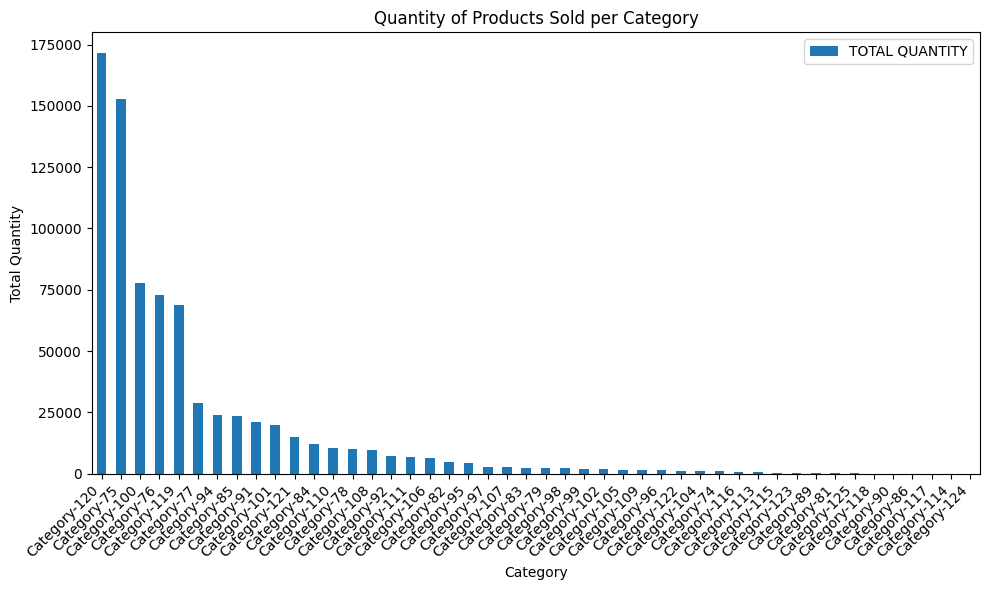

In [103]:
# Plot a graph of QUANTITY against CATEGORIES
# Sort
categorical_sales_sorted = categorical_sales.sort_values(by="TOTAL QUANTITY", ascending=False)
# Plot
categorical_sales_sorted.plot(y="TOTAL QUANTITY", kind="bar", figsize=(10, 6))
plt.title("Quantity of Products Sold per Category")
plt.xlabel("Category")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();

In [ ]:
# Plot a graph of VALUE against CATEGORIES
# Sort
categorical_sales_sorted = categorical_sales.sort_values(by="TOTAL VALUE", ascending=False)
# Plot
categorical_sales_sorted.plot(y="TOTAL VALUE", kind="bar", figsize=(10, 6))
plt.title("Value of Products Sold per Category")
plt.xlabel("Category")
plt.ylabel("Total Value")
plt.xticks(rotation=45, ha='right')
# Format the y-axis to display numbers with commas
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()

#### Sales by Business

In [104]:
# Group by 'ANONYMIZED BUSINESS' and calculate total quantity and value
business_sales = data.groupby("ANONYMIZED BUSINESS").agg({"QUANTITY": "sum", "VALUE": "sum"})
business_sales.rename(columns={"QUANTITY": "TOTAL QUANTITY", "VALUE": "TOTAL VALUE"}, inplace=True)
business_sales.head(10)

,TOTAL QUANTITY,TOTAL VALUE
ANONYMIZED BUSINESS,,
Business-0000,8,10445
Business-0005,1,2645
Business-0029,26,77340
Business-003d,98,221761
Business-0072,127,225056
Business-0078,333,1108125
Business-007a,2,4010
Business-0086,6,11200
Business-00a2,9,20685


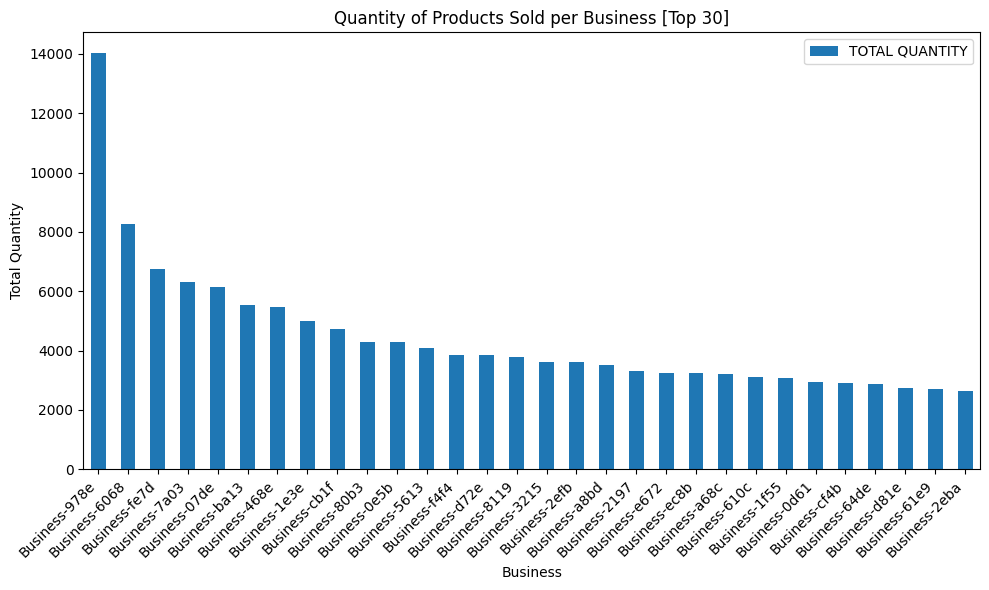

In [105]:
# plot a graph of quantity against business
# Sort
business_sales_sorted = business_sales.sort_values(by="TOTAL QUANTITY", ascending=False)
# Plot Top 30 Businesses
business_sales_sorted.head(30).plot(y="TOTAL QUANTITY", kind="bar", figsize=(10, 6))
plt.title("Quantity of Products Sold per Business [Top 30]")
plt.xlabel("Business")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();

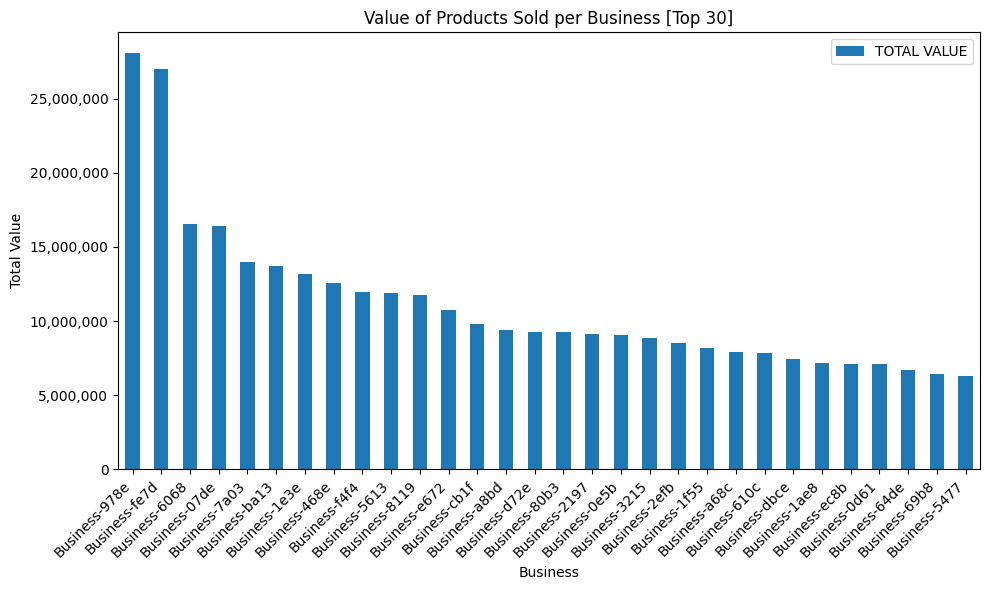

In [106]:
# plot a graph of Total Value against Business
# Sort
business_sales_sorted = business_sales.sort_values(by="TOTAL VALUE", ascending=False)
# Plot Top 30 Businesses
business_sales_sorted.head(30).plot(y="TOTAL VALUE", kind="bar", figsize=(10, 6))
plt.title("Value of Products Sold per Business [Top 30]")
plt.xlabel("Business")
plt.ylabel("Total Value")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout();

#### Sales Trend over Time

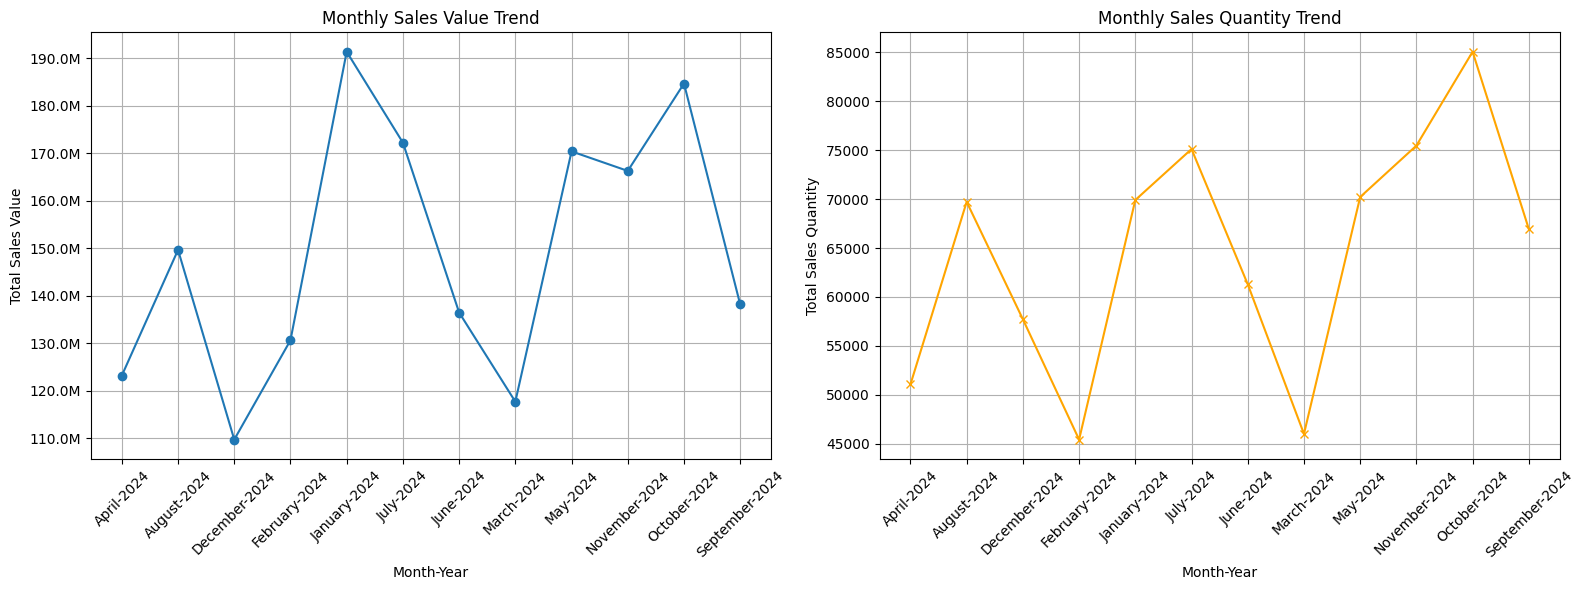

In [114]:
# Group data by month-year and calculate total sales value and quantity
monthly_sales = data.groupby("MONTH-YEAR").agg({"VALUE": "sum", "QUANTITY": "sum"})

# Create two plots (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Value
axes[0].plot(monthly_sales.index, monthly_sales["VALUE"], marker='o')
axes[0].set_xlabel("Month-Year")
axes[0].set_ylabel("Total Sales Value")
axes[0].set_title("Monthly Sales Value Trend")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)
# Format y-axis ticks to show values in millions
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))


# Plot 2: Quantity
axes[1].plot(monthly_sales.index, monthly_sales["QUANTITY"], marker='x', color='orange')
axes[1].set_xlabel("Month-Year")
axes[1].set_ylabel("Total Sales Quantity")
axes[1].set_title("Monthly Sales Quantity Trend")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout();

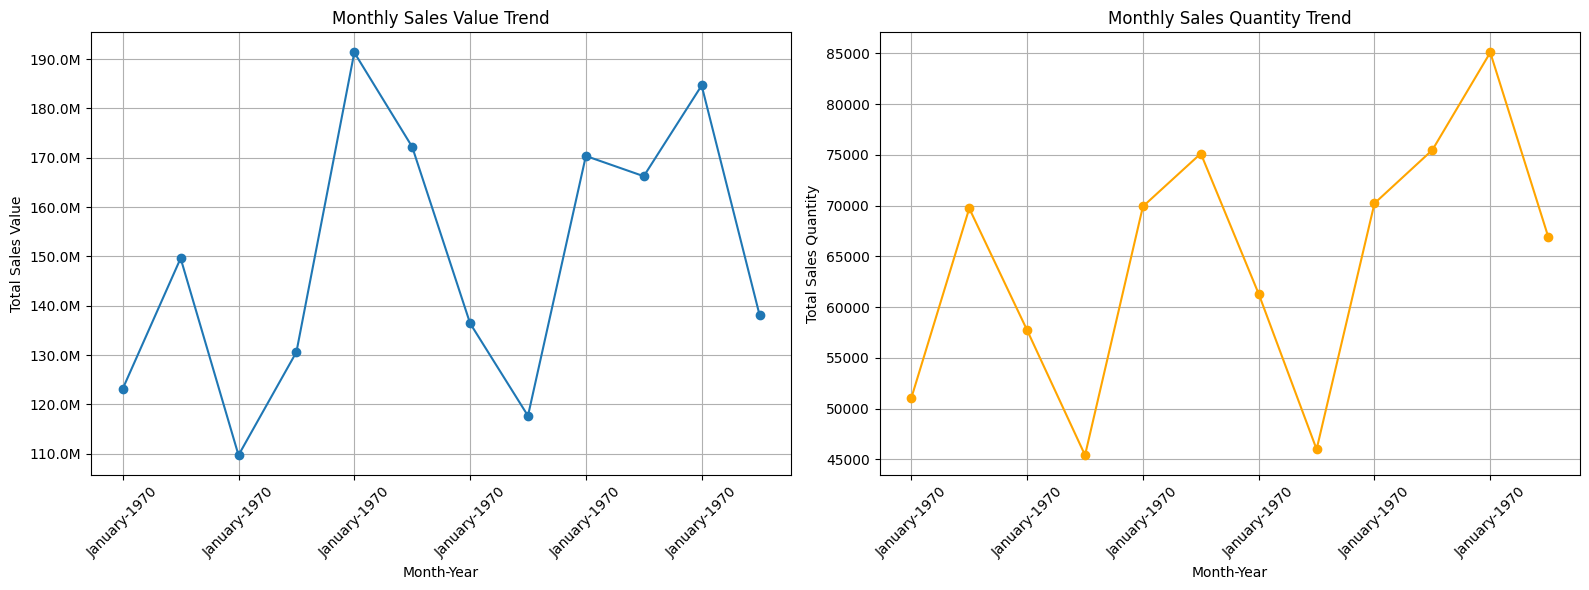

In [113]:
# Group data by month-year and calculate total sales value and quantity
monthly_sales = data.groupby("MONTH-YEAR").agg({"VALUE": "sum", "QUANTITY": "sum"}).reset_index()

# Create two plots (side-by-side)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 1 [Primary Axis]: Value
color = "tab:blue"
ax1.set_xlabel("Month-Year")
ax1.set_ylabel("Value ($)", color=color)
line1 = ax1.plot(monthly_sales["MONTH-YEAR"], monthly_sales["VALUE"], color=color, marker='o', label="Total Sales Value ($)")
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')
# Format y-axis ticks to show values in millions
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))

# Plot 2: Quantity
ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel(Quantity', color=color)
line2 = ax2.plot(monthly_data['MONTH-YEAR'], monthly_data['QUANTITY'], color=color2, marker='s', label='Quantity')
ax2.tick_params(axis='y', labelcolor=color2)

axes[1].plot(monthly_sales.index, monthly_sales["QUANTITY"], marker='o', color='orange')
axes[1].set_xlabel("Month-Year")
axes[1].set_ylabel("Total Sales Quantity")
axes[1].set_title("Monthly Sales Quantity Trend")
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)
axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%B-%Y"))

plt.tight_layout()
plt.show()


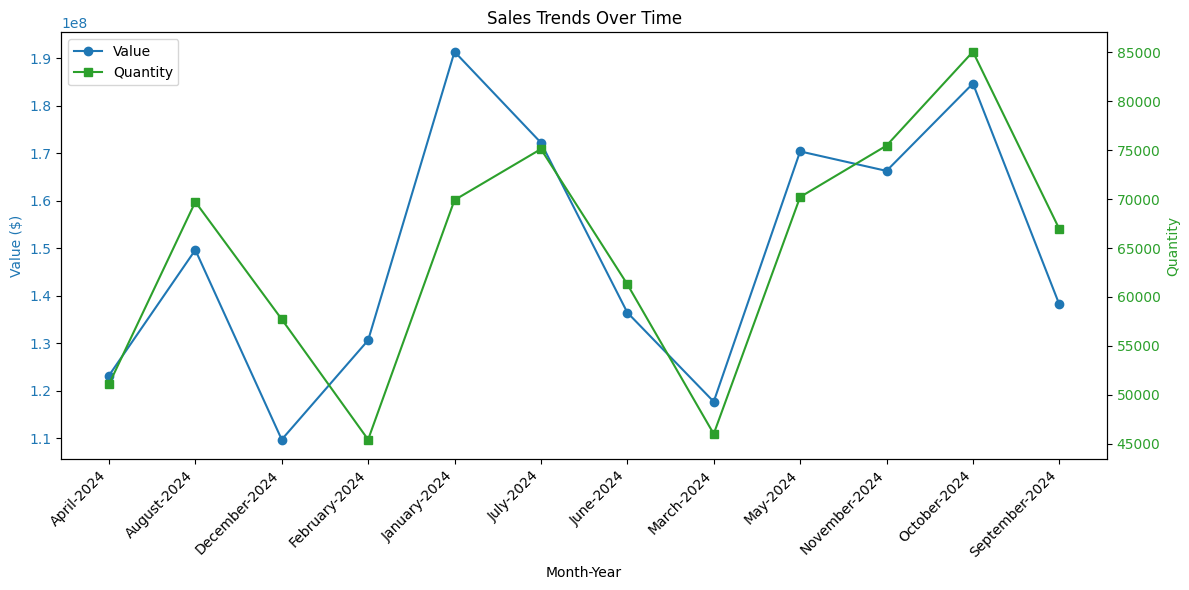

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_sales_trends(df):
    """
    Create a time series plot of sales trends showing both Value and Quantity

    Parameters:
    df (pandas.DataFrame): DataFrame with columns DATE, QUANTITY, and VALUE
    """
    # Convert DATE to datetime if it's not already
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Group by MONTH-YEAR and calculate sums
    monthly_data = df.groupby('MONTH-YEAR').agg({
        'VALUE': 'sum',
        'QUANTITY': 'sum'
    }).reset_index()

    # Create figure and axis objects with a single subplot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Value on primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Value ($)', color=color)
    line1 = ax1.plot(monthly_data['MONTH-YEAR'], monthly_data['VALUE'],
                     color=color, marker='o', label='Value')
    ax1.tick_params(axis='y', labelcolor=color)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Create second y-axis for Quantity
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Quantity', color=color)
    line2 = ax2.plot(monthly_data['MONTH-YEAR'], monthly_data['QUANTITY'],
                     color=color, marker='s', label='Quantity')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Add title and adjust layout
    plt.title('Sales Trends Over Time')
    plt.tight_layout()

    return fig

# Example usage:
# Assuming your data is in a DataFrame called 'df'
plot_sales_trends(data);
# plt.show()

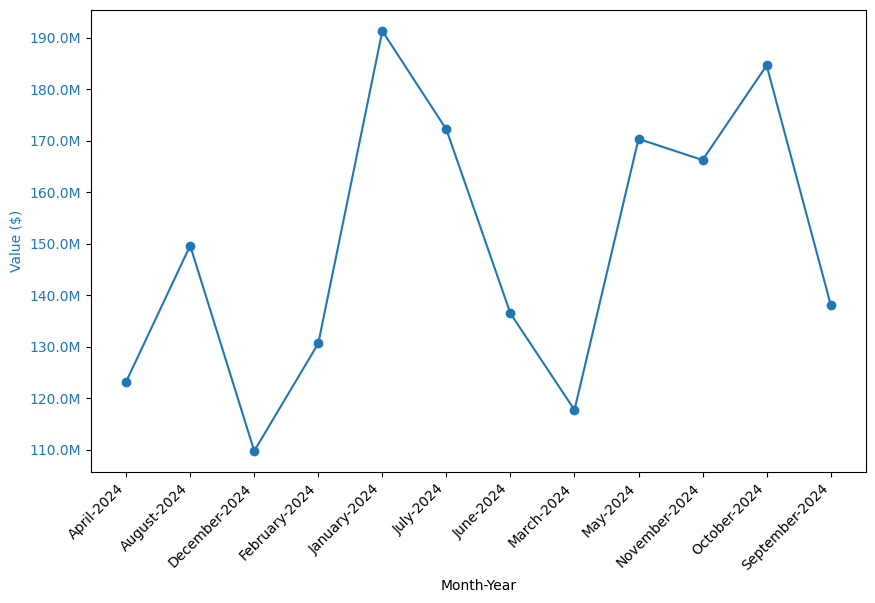

In [116]:
# Group data by month-year and calculate total sales value and quantity
monthly_sales = data.groupby("MONTH-YEAR").agg({"VALUE": "sum", "QUANTITY": "sum"}).reset_index()

# Create two plots (side-by-side)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 1 [Primary Axis]: Value
color = 'tab:blue'
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Value ($)', color=color)
line1 = ax1.plot(monthly_sales["MONTH-YEAR"], monthly_sales["VALUE"], color=color, marker='o', label="Total Sales Value ($)")
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')
# Format y-axis ticks to show values in millions
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x / 1_000_000:.1f}M"))

